In [1]:
import pandas as pd
import numpy as np
import holidays
import shap

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import datetime

from matplotlib import pyplot as plt

pd.set_option("display.max_columns", None)

In [2]:
def smape(actual, predicted) -> float:  
    temporary_smape_nominator = np.abs(np.array(actual) - np.array(predicted))
    temporary_smape_denominator = [np.max(elem) for elem in list(zip(predicted, actual))]

    return float(np.sum(temporary_smape_nominator) / np.sum(temporary_smape_denominator))

def regression_insights(actual, predicted) -> tuple: 
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)

    return mse, rmse, mae, r2

def bias(actual, predicted) -> float:
    return float(np.sum(np.abs(1 - np.array(predicted) / np.array(actual + 0.00000001))))

In [3]:
weekly_data = pd.read_csv("../podaci/vremenske-serije/weekly_data_xgboost.csv")

In [4]:
weekly_data.head()

,year_week,target_1,ds,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,target_2,target_3,target_4,number_of_holidays,number_of_holidays_next_week,number_of_holidays_previous_week
0,201951,0.143667,2019-12-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.294896,0.139887,0.332703,0,4,0
1,201952,0.294896,2019-12-23,0.143667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.139887,0.332703,0.790170,4,1,0
2,202001,0.139887,2019-12-30,0.294896,0.143667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.332703,0.790170,0.920605,1,1,4
3,202002,0.332703,2020-01-06,0.139887,0.294896,0.143667,NaN,NaN,NaN,NaN,NaN,NaN,0.790170,0.920605,0.914934,1,0,1
4,202003,0.790170,2020-01-13,0.332703,0.139887,0.294896,0.143667,NaN,NaN,NaN,NaN,NaN,0.920605,0.914934,0.769376,0,0,1


In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

#covariates = ["week_1", "week_2", "week_3"]
covariates = ["week_1", "week_2", "week_3", "week_4", 
              "week_5", "week_6", "week_7", "week_8",
              "week_9", "number_of_holidays",
              "number_of_holidays_next_week", 
              "number_of_holidays_previous_week"]


def run_xgboost(xgb_train_pd, xgb_test_pd, model_info, look_ahead=1):
    predictions = {"target_1":{}, "target_2":{}, "target_3":{}, "target_4":{}}

    for instance in range(len(xgb_test_pd)):
        #start_date = xgb_test_pd.iloc[instance]['ds']

        # Create training + validation data set
        training_and_validation_pd = pd.concat([xgb_train_pd, xgb_test_pd.iloc[:instance]])
        X_train, X_validation, y_train, y_validation = train_test_split(
          training_and_validation_pd[covariates],
          training_and_validation_pd[["target_1", "target_2", "target_3", "target_4"]],
          test_size=0.2,
          random_state=42
        )

        for i in range(look_ahead):
            if i + instance < len(xgb_test_pd):
                #target = xgb_train_pd[f"target_{i+1}"]
                prediction_date = xgb_test_pd.iloc[instance+i].ds

                future_to_predict = y_validation
                model = xgb.XGBRegressor(**{"objective": "reg:squarederror", "seed": 42})
                model = model.fit(
                  X_train,
                  y_train[[f"target_{i+1}"]],
                  eval_metric=["rmse"],
                  eval_set=[(X_train, y_train[[f"target_{i+1}"]]), 
                            (X_validation, y_validation[[f"target_{i+1}"]])],
                  early_stopping_rounds=30,
                  verbose=False
                )
                output = model.predict(xgb_test_pd.iloc[[instance]][covariates])
                future_to_predict = xgb_test_pd.iloc[instance]['ds'] + datetime.timedelta(days=i*7)
                predictions[f"target_{i+1}"][future_to_predict] = output[0]
                #predictions_on_specific_day.append((future_to_predict, output[0]))
    
    return predictions, model

In [10]:
weekly_data = weekly_data.astype({"year_week": 'str', "ds": 'datetime64[ns]'})

In [11]:
week_to_start = "202109"
train_pd = weekly_data[weekly_data["year_week"] < week_to_start]
test_pd =  weekly_data[weekly_data["year_week"] >= week_to_start]

In [13]:
test_pd

,year_week,target_1,ds,week_1,week_2,week_3,week_4,week_5,week_6,week_7,week_8,week_9,target_2,target_3,target_4,number_of_holidays,number_of_holidays_next_week,number_of_holidays_previous_week
63,202109,1.017013,2021-03-01,1.122873,0.939509,0.909263,1.045369,1.132325,1.000000,0.982987,0.841210,0.396975,1.018904,0.930057,1.015123,0,0,0
64,202110,1.018904,2021-03-08,1.017013,1.122873,0.939509,0.909263,1.045369,1.132325,1.000000,0.982987,0.841210,0.930057,1.015123,0.894140,0,0,0
65,202111,0.930057,2021-03-15,1.018904,1.017013,1.122873,0.939509,0.909263,1.045369,1.132325,1.000000,0.982987,1.015123,0.894140,0.916824,0,0,0
66,202112,1.015123,2021-03-22,0.930057,1.018904,1.017013,1.122873,0.939509,0.909263,1.045369,1.132325,1.000000,0.894140,0.916824,1.119093,0,2,0
67,202113,0.894140,2021-03-29,1.015123,0.930057,1.018904,1.017013,1.122873,0.939509,0.909263,1.045369,1.132325,0.916824,1.119093,1.026465,2,1,0
68,202114,0.916824,2021-04-05,0.894140,1.015123,0.930057,1.018904,1.017013,1.122873,0.939509,0.909263,1.045369,1.119093,1.026465,1.119093,1,0,2
69,202115,1.119093,2021-04-12,0.916824,0.894140,1.015123,0.930057,1.018904,1.017013,1.122873,0.939509,0.909263,1.026465,1.119093,1.000000,0,0,1
70,202116,1.026465,2021-04-19,1.119093,0.916824,0.894140,1.015123,0.930057,1.018904,1.017013,1.122873,0.939509,1.119093,1.000000,0.759924,0,1,0
71,202117,1.119093,2021-04-26,1.026465,1.119093,0.916824,0.894140,1.015123,0.930057,1.018904,1.017013,1.122873,1.000000,0.759924,0.937618,1,0,0
72,202118,1.000000,2021-05-03,1.119093,1.026465,1.119093,0.916824,0.894140,1.015123,0.930057,1.018904,1.017013,0.759924,0.937618,1.060491,0,1,1


In [14]:
model_xgboost = run_xgboost(train_pd.dropna(), 
                            test_pd, 
                            model_info="nothing", 
                            look_ahead=4)

In [17]:
xgb_results = pd.DataFrame(data=[val for key,val in model_xgboost[0].items()]).T.rename(columns={0:"target_1", 1:"target_2", 2:"target_3", 3:"target_4"})
xgb_results

,target_1,target_2,target_3,target_4
2021-03-01,1.128921,NaN,NaN,NaN
2021-03-08,0.940977,1.003685,NaN,NaN
2021-03-15,1.112357,0.948605,1.029409,NaN
2021-03-22,0.868490,0.963285,1.021858,0.998651
2021-03-29,0.887852,0.651487,0.964055,0.927277
2021-04-05,0.912433,1.057817,0.784090,0.894802
2021-04-12,1.067139,1.003985,0.931291,0.957739
2021-04-19,1.158182,1.074783,0.940411,0.929667
2021-04-26,0.991896,0.916037,0.955429,1.072130
2021-05-03,1.311471,0.966038,1.045138,1.064855


In [18]:
# 2021-04-01
final_df = xgb_results.dropna(axis=0, how='any')
final_df['date'] = final_df.index


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
final_df

,target_1,target_2,target_3,target_4,date
2021-03-22,0.868490,0.963285,1.021858,0.998651,2021-03-22
2021-03-29,0.887852,0.651487,0.964055,0.927277,2021-03-29
2021-04-05,0.912433,1.057817,0.784090,0.894802,2021-04-05
2021-04-12,1.067139,1.003985,0.931291,0.957739,2021-04-12
2021-04-19,1.158182,1.074783,0.940411,0.929667,2021-04-19
2021-04-26,0.991896,0.916037,0.955429,1.072130,2021-04-26
2021-05-03,1.311471,0.966038,1.045138,1.064855,2021-05-03
2021-05-10,0.993422,1.211497,1.112207,1.054003,2021-05-10
2021-05-17,0.950806,1.135883,0.952618,0.962979,2021-05-17
2021-05-24,1.022062,0.990021,1.113118,1.156240,2021-05-24


In [22]:
actual = weekly_data[weekly_data['ds'] >='2021-03-22'][['ds', 'target_1']]
len(actual), len(final_df)

(11, 11)

In [26]:
actual

,ds,target_1
66,2021-03-22,1.015123
67,2021-03-29,0.894140
68,2021-04-05,0.916824
69,2021-04-12,1.119093
70,2021-04-19,1.026465
71,2021-04-26,1.119093
72,2021-05-03,1.000000
73,2021-05-10,0.759924
74,2021-05-17,0.937618
75,2021-05-24,1.060491


In [23]:
final_df.insert(0, "actual", list(actual['target_1']))

In [24]:
final_df

,actual,target_1,target_2,target_3,target_4,date
2021-03-22,1.015123,0.868490,0.963285,1.021858,0.998651,2021-03-22
2021-03-29,0.894140,0.887852,0.651487,0.964055,0.927277,2021-03-29
2021-04-05,0.916824,0.912433,1.057817,0.784090,0.894802,2021-04-05
2021-04-12,1.119093,1.067139,1.003985,0.931291,0.957739,2021-04-12
2021-04-19,1.026465,1.158182,1.074783,0.940411,0.929667,2021-04-19
2021-04-26,1.119093,0.991896,0.916037,0.955429,1.072130,2021-04-26
2021-05-03,1.000000,1.311471,0.966038,1.045138,1.064855,2021-05-03
2021-05-10,0.759924,0.993422,1.211497,1.112207,1.054003,2021-05-10
2021-05-17,0.937618,0.950806,1.135883,0.952618,0.962979,2021-05-17
2021-05-24,1.060491,1.022062,0.990021,1.113118,1.156240,2021-05-24


In [27]:
columns = final_df.columns
metrics = []

for column in columns:
    df = final_df[['date', column]]
        
    dict_metrics = {}
    dict_metrics['model'] = column

    if (list(actual['ds']) == list(df['date'])):
        mse, rmse, mae, r2 = regression_insights(actual['target_1'], df[column])
        dict_metrics['mse'] = mse
        dict_metrics['rmse'] = rmse
        dict_metrics['mae'] = mae
        dict_metrics['r2'] = r2

        smape_value = smape(actual['target_1'], df[column])
        dict_metrics['smape'] = smape_value

        bias_value = bias(actual['target_1'], df[column])
        dict_metrics['bias'] = bias_value
        metrics.append(dict_metrics.copy())

metrics_df = pd.DataFrame.from_dict(metrics)

In [28]:
metrics_df

,model,mse,rmse,mae,r2,smape,bias
0,actual,0.000000,0.000000,0.000000,1.000000,0.000000,1.226973e-07
1,target_1,0.046059,0.214613,0.146229,-0.575582,0.138842,2.195093e+00
2,target_2,0.053158,0.230559,0.181838,-0.818429,0.171918,2.596678e+00
3,target_3,0.038456,0.196103,0.141932,-0.315520,0.137645,2.095372e+00
4,target_4,0.041360,0.203371,0.128912,-0.414843,0.124105,2.043085e+00


In [30]:
model_xgboost[1].feature_importances_

array([0.0935186 , 0.07290884, 0.03916082, 0.01083607, 0.05061333,
       0.03285531, 0.01028685, 0.02472068, 0.01072453, 0.58744645,
       0.05859031, 0.0083382 ], dtype=float32)

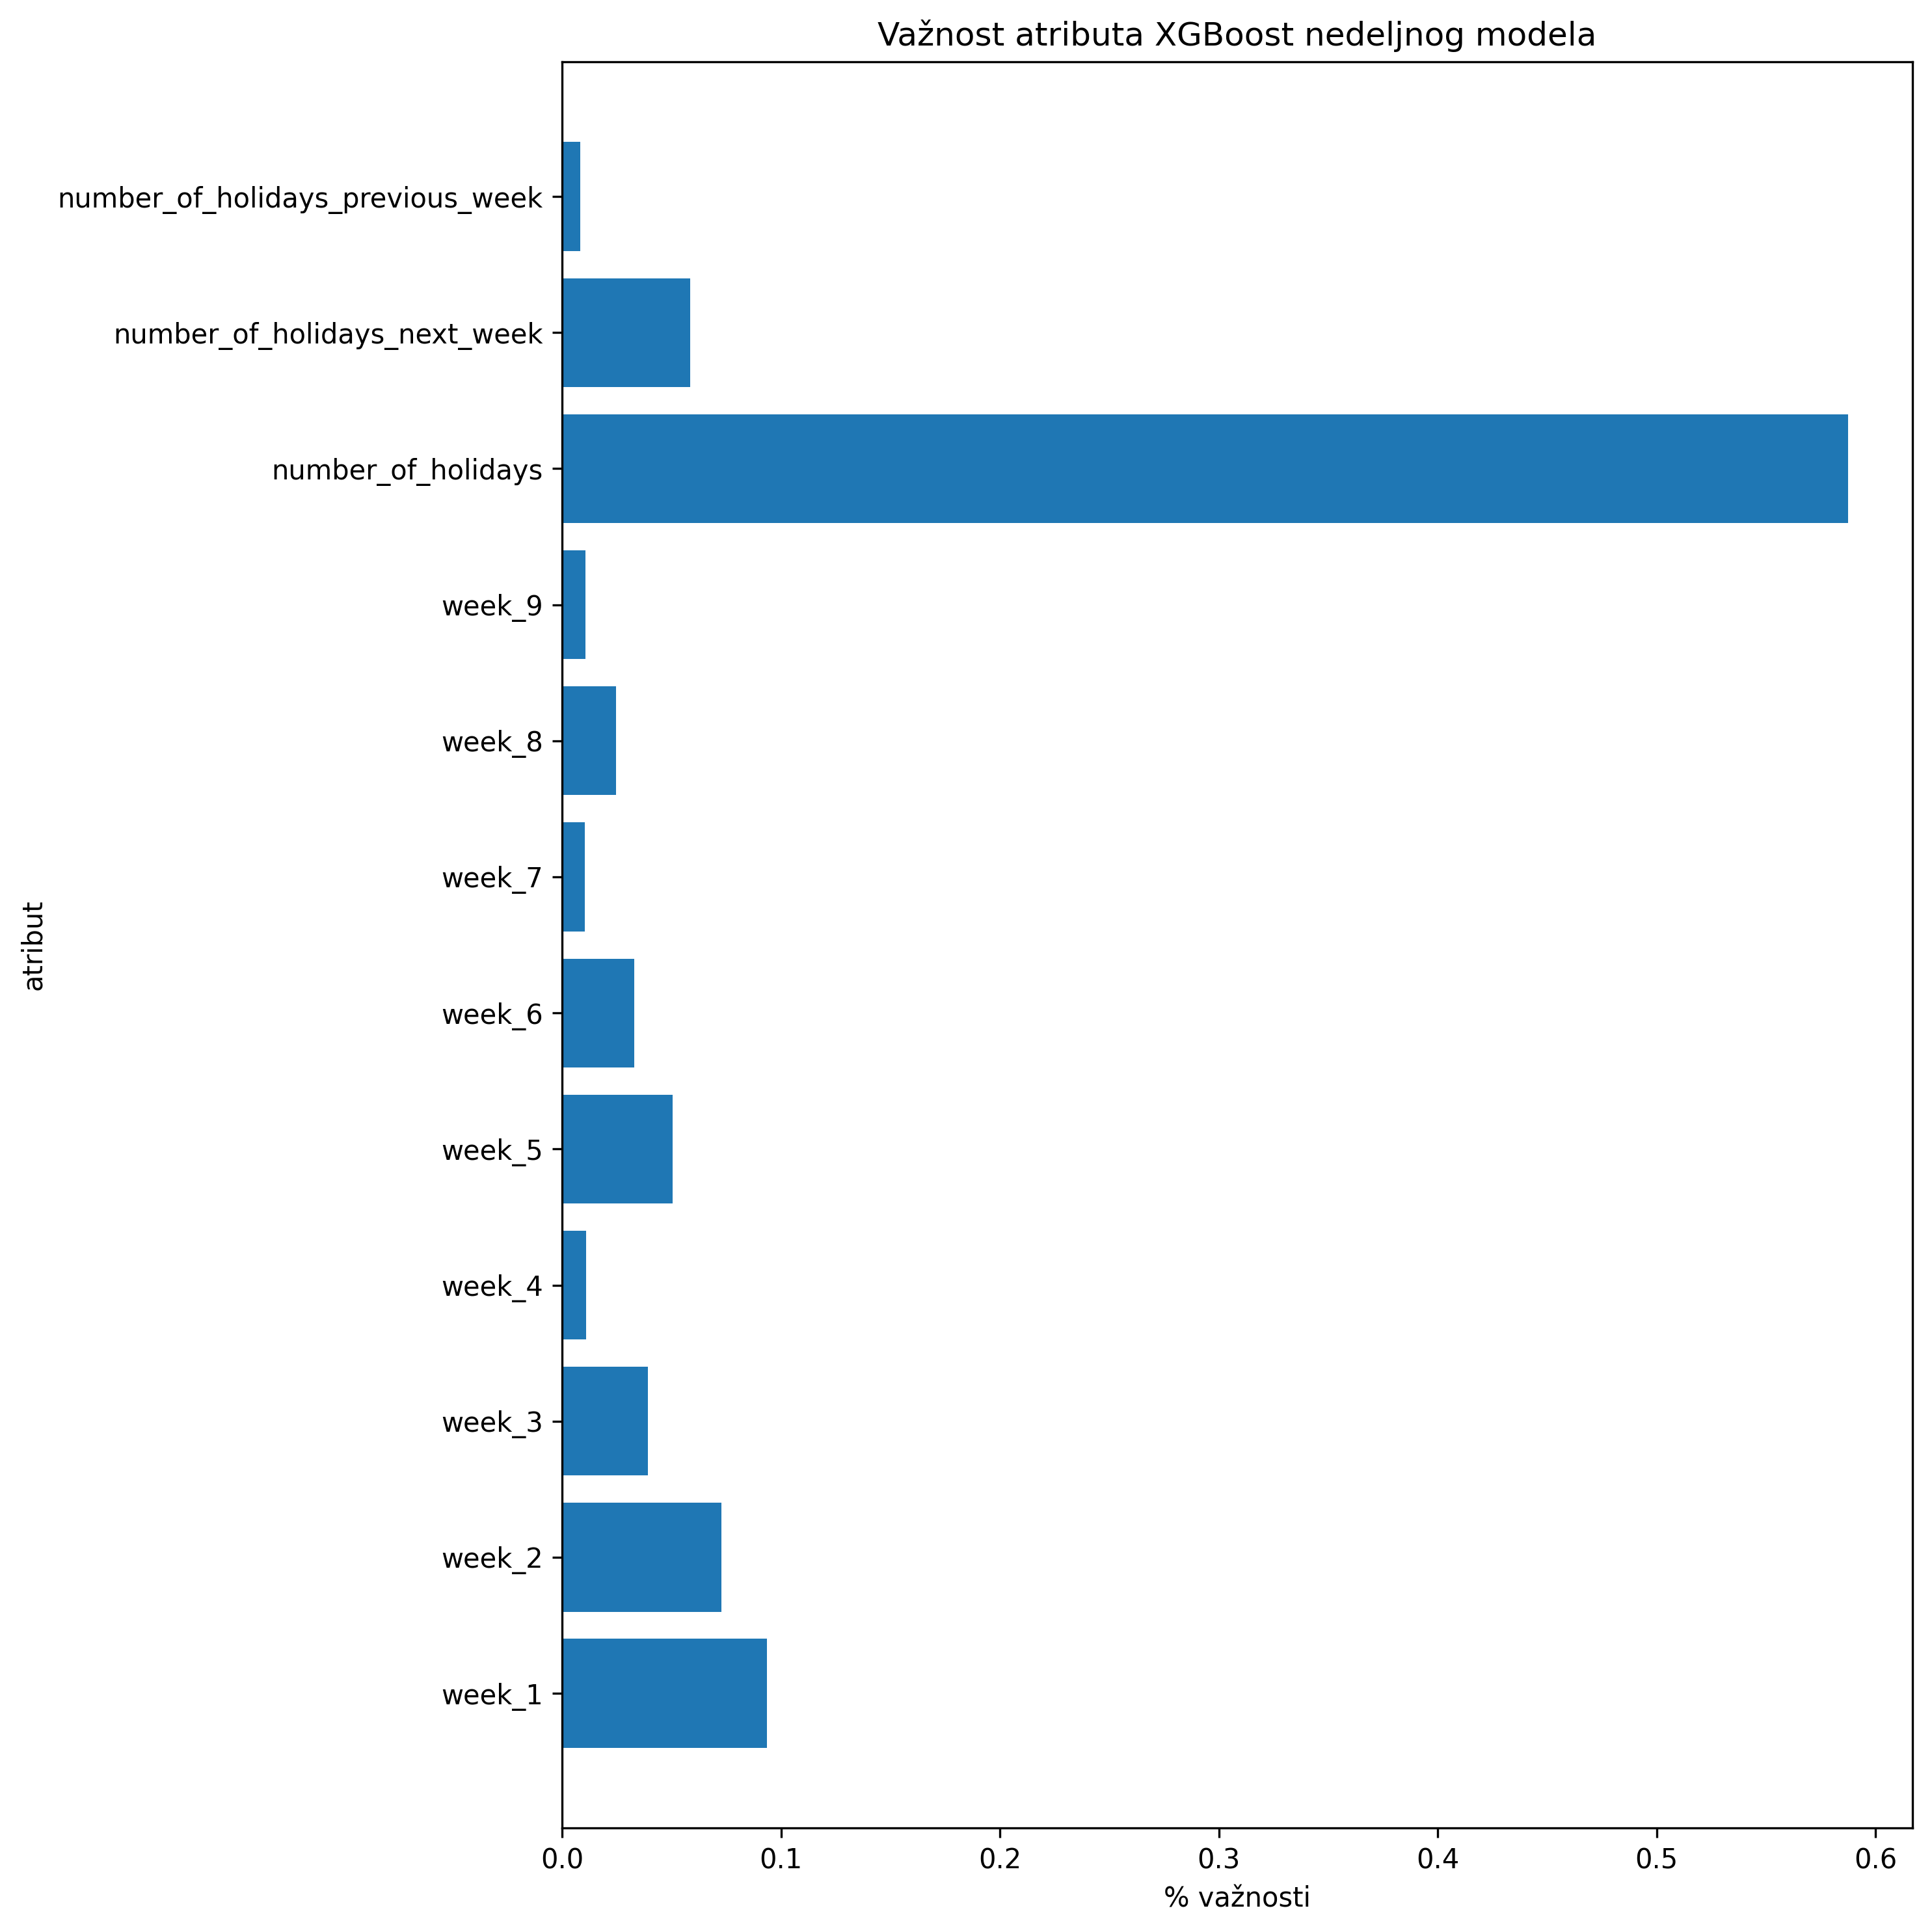

In [37]:
plt.figure(figsize=(10, 10), dpi=300)
plt.title("Važnost atributa XGBoost nedeljnog modela")
plt.barh(covariates, list(model_xgboost[1].feature_importances_))
plt.xlabel("% važnosti")
plt.ylabel("atribut")
plt.tight_layout()
plt.savefig("../../grafici/xgboost_nedeljni_vaznost_atributa.eps", dpi=300)